### Sample program for LSTM (N-d input/output)  
https://oku.edu.mie-u.ac.jp/~okumura/stat/160118.html  

#### Import libraries  

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#### Parameters  

In [22]:
np.random.seed(11)
tf.random.set_seed(11)

# To show more rows and columns without "..."
pd.options.display.max_columns=999
pd.options.display.max_rows=999

#### Read CSV file  

In [23]:
# read data
df = pd.read_csv('weather_in_tokyo_and_icecream_in_japan-utf8.csv',
                 delimiter=',',skiprows=6, header=0)
print(df.shape)
print(df.info())
display(df.head())

(120, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   120 non-null    object 
 1   x1      120 non-null    float64
 2   x2      120 non-null    float64
 3   x3      120 non-null    int64  
 4   x4      120 non-null    int64  
 5   y1      120 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 5.8+ KB
None


,Month,x1,x2,x3,x4,y1
0,2003-1,9.3,101.0,46,0,331
1,2003-2,9.9,53.5,52,0,268
2,2003-3,12.7,159.5,49,0,365
3,2003-4,19.2,121.0,61,3,492
4,2003-5,22.4,172.5,65,7,632


#### Convert datatype of Month column to 'datetime'  

In [24]:
df['Month'] = pd.to_datetime(df['Month'])
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   120 non-null    datetime64[ns]
 1   x1      120 non-null    float64       
 2   x2      120 non-null    float64       
 3   x3      120 non-null    int64         
 4   x4      120 non-null    int64         
 5   y1      120 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 5.8 KB
None


,Month,x1,x2,x3,x4,y1
0,2003-01-01,9.3,101.0,46,0,331
1,2003-02-01,9.9,53.5,52,0,268
2,2003-03-01,12.7,159.5,49,0,365
3,2003-04-01,19.2,121.0,61,3,492
4,2003-05-01,22.4,172.5,65,7,632


#### Time series plot  

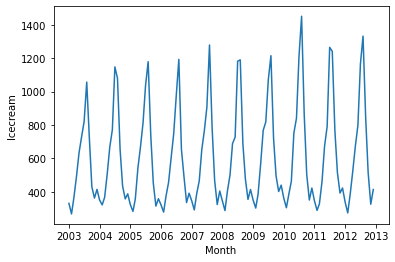

In [25]:
plt.plot(df['Month'], df['y1'])
plt.xlabel('Month')
plt.ylabel('Icecream')
plt.show()

#### Set parameters for training / prediction  

In [26]:
w = 24
n_out = 12
n_test = 12

#### Standardization of training data  

In [27]:
sc = MinMaxScaler(feature_range=(0, 1), copy=True)
xy = df.drop(columns='Month')
sc.fit(xy[:-n_test])
xy_std = sc.transform(xy)
print(xy_std.shape)

(120, 5)


#### Prepare for train data and teacher signal  

In [28]:
weather = xy_std[:, :-1]
print(weather.shape)
display(weather[:5])

(120, 4)


array([[0.032     , 0.12556343, 0.25641026, 0.        ],
       [0.056     , 0.0643915 , 0.41025641, 0.        ],
       [0.168     , 0.20090148, 0.33333333, 0.        ],
       [0.428     , 0.15132003, 0.64102564, 0.09677419],
       [0.556     , 0.21764327, 0.74358974, 0.22580645]])

In [29]:
icecream = xy_std[:, -1]
print(icecream.shape)
print(icecream[:5])
print(icecream)

(120,)
[0.05325444 0.         0.08199493 0.18934911 0.30769231]
[0.05325444 0.         0.08199493 0.18934911 0.30769231 0.39053254
 0.46745562 0.66694844 0.38546069 0.13693998 0.08030431 0.12426036
 0.07016061 0.04564666 0.08368555 0.20287405 0.33727811 0.4260355
 0.74387151 0.68639053 0.32544379 0.14032122 0.07607777 0.10143702
 0.04649197 0.01267963 0.07523246 0.23245985 0.33727811 0.45984784
 0.65004227 0.77007608 0.39814032 0.15638208 0.0397295  0.07692308
 0.04564666 0.00929839 0.0887574  0.15976331 0.28233305 0.4057481
 0.59594252 0.7819104  0.3262891  0.19019442 0.05748098 0.10481826
 0.06677937 0.0202874  0.10059172 0.16737109 0.32459848 0.42265427
 0.54099746 0.85460693 0.43617921 0.16990702 0.04733728 0.11580727
 0.06593407 0.01690617 0.11496196 0.19695689 0.35587489 0.38799662
 0.772612   0.77937447 0.35756551 0.17666948 0.07354184 0.12341505
 0.07016061 0.0295858  0.09974641 0.25443787 0.42265427 0.465765
 0.67962806 0.80050719 0.38461538 0.19188504 0.11327134 0.14539307
 0

#### Prepare for windows of data  

In [30]:
x = []
y = []

n_months = icecream.shape[0]

for i in range(0, n_months-w-n_out):
    x.append(weather[i:i+w])
    y.append(icecream[i+w:i+w+n_out])
x = np.array(x)
y = np.array(y)
print(x.shape, y.shape)  # debug
print(x[:3])
print(y[:3])

(84, 24, 4) (84, 12)
[[[0.032      0.12556343 0.25641026 0.        ]
  [0.056      0.0643915  0.41025641 0.        ]
  [0.168      0.20090148 0.33333333 0.        ]
  [0.428      0.15132003 0.64102564 0.09677419]
  [0.556      0.21764327 0.74358974 0.22580645]
  [0.724      0.10495815 0.84615385 0.67741935]
  [0.7        0.23696072 1.         0.67741935]
  [0.84       0.4719897  0.94871795 0.83870968]
  [0.784      0.1886671  0.76923077 0.74193548]
  [0.516      0.21635544 0.58974359 0.09677419]
  [0.356      0.29104958 0.79487179 0.        ]
  [0.188      0.06374759 0.35897436 0.        ]
  [0.064      0.         0.17948718 0.        ]
  [0.176      0.0212492  0.23076923 0.        ]
  [0.22       0.16226658 0.43589744 0.        ]
  [0.512      0.08499678 0.38461538 0.09677419]
  [0.608      0.18737927 0.79487179 0.41935484]
  [0.76       0.14037347 0.76923077 0.77419355]
  [0.984      0.0257566  0.66666667 1.        ]
  [0.9        0.09787508 0.74358974 0.90322581]
  [0.808      0.246

#### Model building  

In [31]:
n_hidden = 20

# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss',
                      patience=10, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(x.shape[1],x.shape[2]),
               return_sequences=False))
model.add(Dense(n_out, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2000      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                252       
Total params: 2,252
Trainable params: 2,252
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss="mean_squared_error", optimizer='adam')

#### Training (learning)  

In [33]:
%%time

# Learning 
n_epochs = 500
val_split = 0.2
batch_size = 1

fit_log = model.fit(x[:-n_test], y[:-n_test], batch_size=batch_size, epochs=n_epochs,
                    validation_split=val_split, callbacks=[es_cb])

Epoch 1/500
57/57 [==============================] - 2s 14ms/step - loss: 0.0944 - val_loss: 0.0928
Epoch 2/500
57/57 [==============================] - 0s 8ms/step - loss: 0.0629 - val_loss: 0.0868
Epoch 3/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0573 - val_loss: 0.0840
Epoch 4/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0534 - val_loss: 0.0801
Epoch 5/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0492 - val_loss: 0.0716
Epoch 6/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0415 - val_loss: 0.0577
Epoch 7/500
57/57 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0463
Epoch 8/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0372
Epoch 9/500
57/57 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0306
Epoch 10/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0268
Epoch 11

#### Do prediction  

In [34]:
# Against training data
pred = model.predict(x[:-n_test])
print(pred.shape)  # debug

(72, 12)


In [35]:
# Future prediction
future_test = x[-n_test:]
print(future_test.shape)
print(future_test[:3])

(12, 24, 4)
[[[0.068      0.17836446 0.30769231 0.        ]
  [0.12       0.05537669 0.35897436 0.        ]
  [0.208      0.12234385 0.30769231 0.        ]
  [0.468      0.20476497 0.46153846 0.03225806]
  [0.604      0.30714746 0.71794872 0.29032258]
  [0.692      0.28654218 0.92307692 0.51612903]
  [0.832      0.09658725 0.92307692 0.90322581]
  [0.864      0.30714746 0.84615385 0.96774194]
  [0.72       0.06374759 0.71794872 0.67741935]
  [0.552      0.35157759 0.71794872 0.16129032]
  [0.34       0.19059884 0.69230769 0.03225806]
  [0.156      0.10173857 0.38461538 0.        ]
  [0.1        0.00708307 0.12820513 0.        ]
  [0.056      0.14359305 0.61538462 0.        ]
  [0.188      0.1802962  0.64102564 0.        ]
  [0.324      0.27108822 0.66666667 0.03225806]
  [0.58       0.14230522 0.61538462 0.25806452]
  [0.76       0.13457824 0.79487179 0.77419355]
  [0.924      0.0856407  0.87179487 1.        ]
  [1.         0.03026401 0.79487179 1.        ]
  [0.82       0.54668384 0.8

In [36]:
future_result = model.predict(future_test)
print(future_result.shape)

(12, 12)


#### Generalization performance  

In [37]:
mse = mean_squared_error(y[-n_test:], future_result)
print('mse=', mse)

mse= 0.004921396638068253


#### Plot of the results  

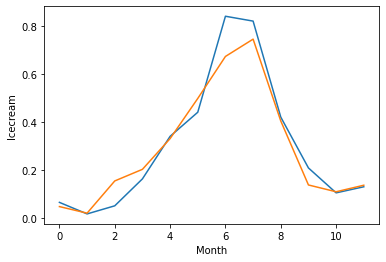

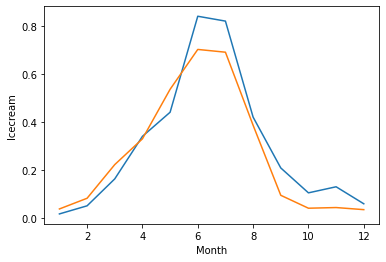

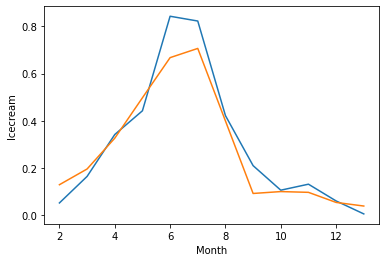

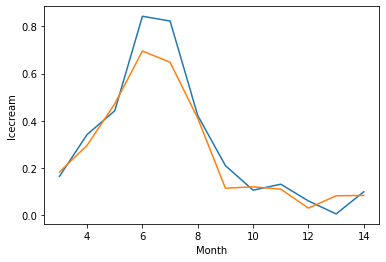

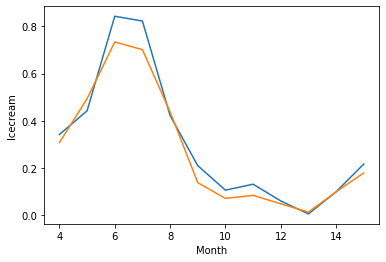

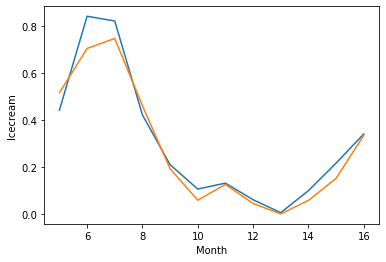

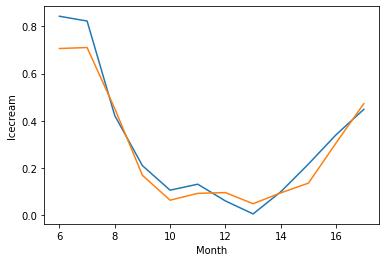

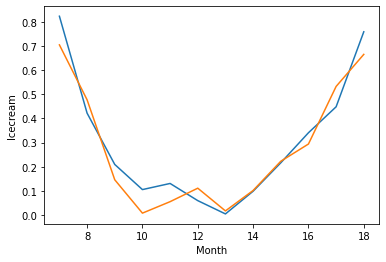

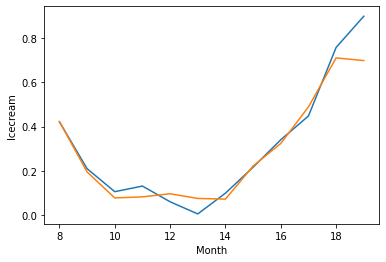

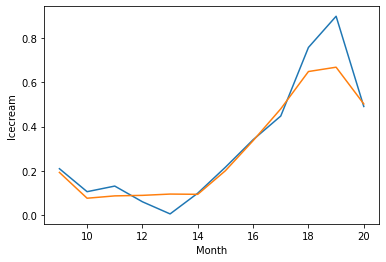

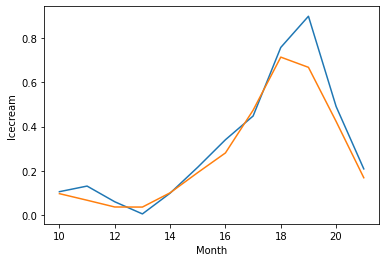

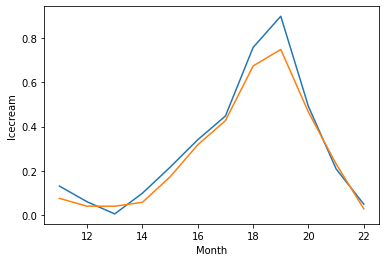

In [38]:
for i in range(n_test):
    plt.plot(range(i,i+n_out), y[i-n_test])
    plt.plot(range(i,i+n_out), future_result[i])
    plt.xlabel('Month')
    plt.ylabel('Icecream')
    plt.show()

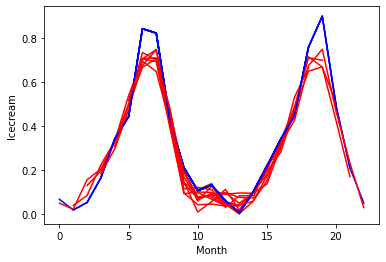

In [39]:
for i in range(n_test):
    plt.plot(range(i,i+n_out), y[i-n_test], c='b')
    plt.plot(range(i,i+n_out), future_result[i], c='r')
plt.xlabel('Month')
plt.ylabel('Icecream')
plt.show()

#### Plot of the log during the training  

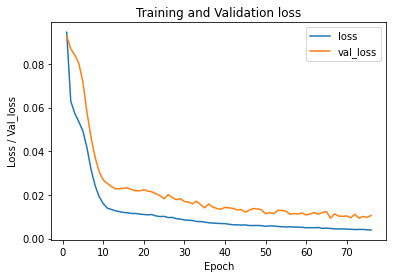

In [40]:
# Plot Training loss & Validation Loss
loss = fit_log.history["loss"]
val_loss = fit_log.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="loss" )
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Training and Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss / Val_loss')
plt.legend()
plt.show()